# Selección de Características
# Ejemplos Varios<a class="tocSkip">
## Reconocimiento de Patrones <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**

# Example: Facial Recognition with LBP and PCA,ICA,PLSR

This example shows how to use LBP in face recognition. This method has been widely used on frontal and well aligned faces.


In this example, facial recognition is performed on a well-known database(*) containing 40 people, each with 10 facial photos. This database is known to be "easy", since the photos are of frontal faces and taken on the same day, which indicates that there are not many changes in appearance within the 10 photos of each person. Here are some examples.

(*) [ORL database](https://paperswithcode.com/dataset/orl)



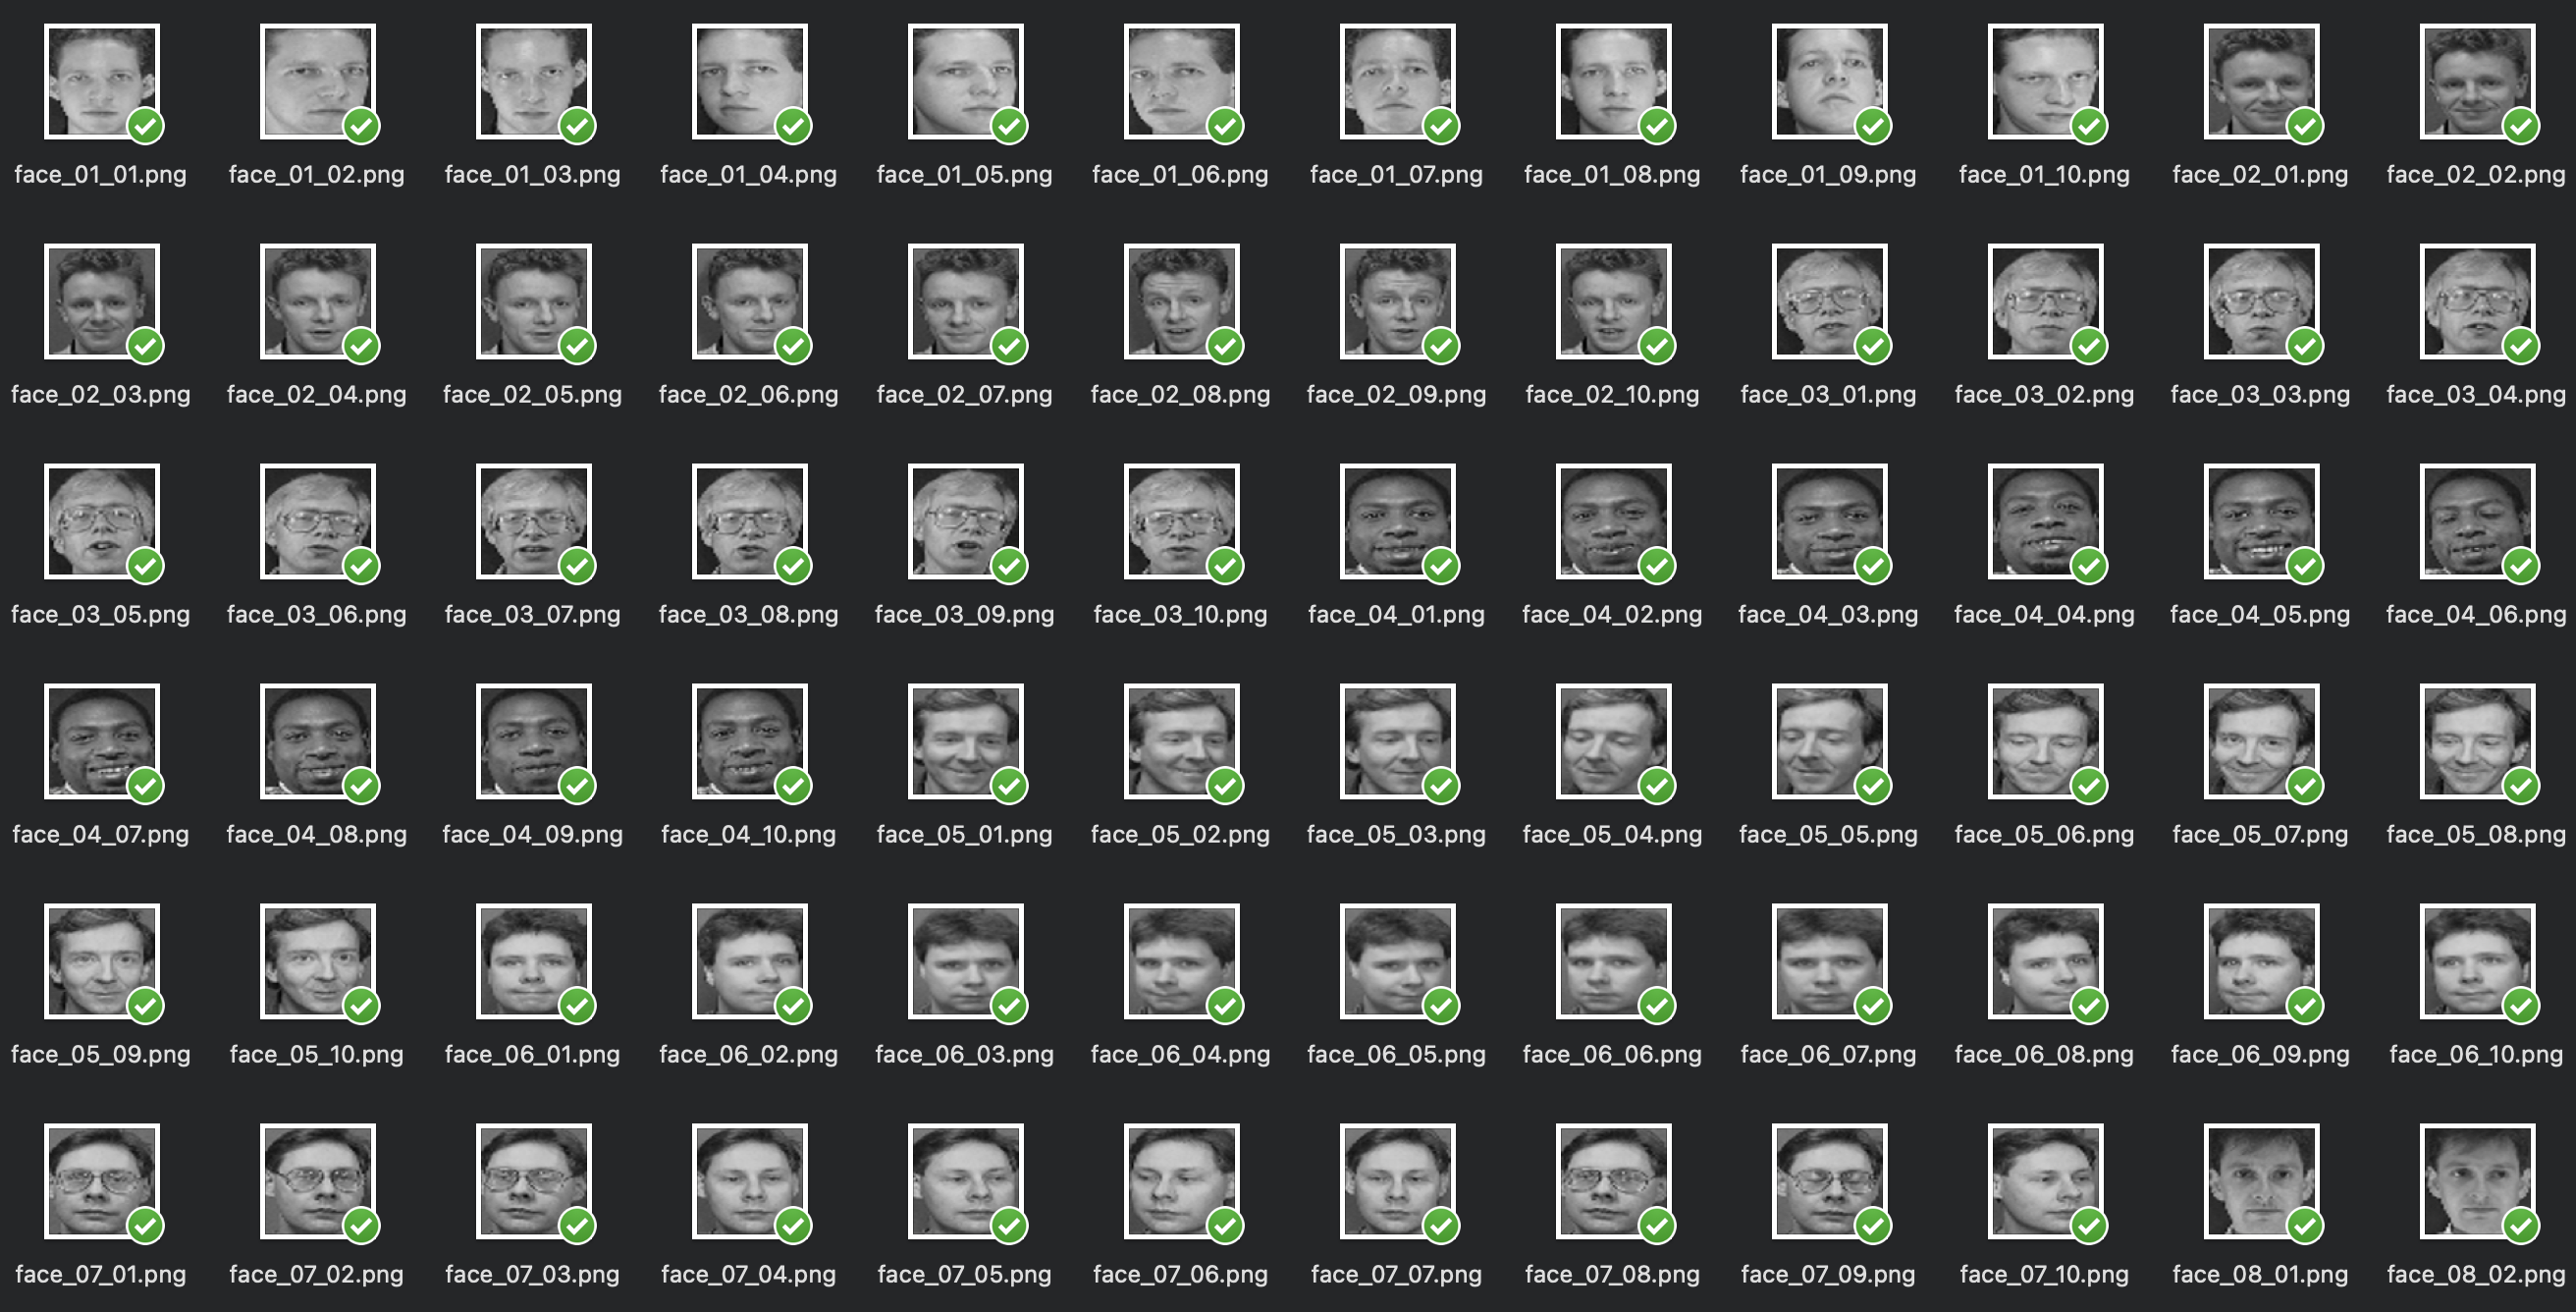

## Libraries



In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tqdm
from itertools import combinations
#from tqdm import tqdm, trange
#from tqdm import trange
from   tqdm.auto import tqdm
import skimage
from scipy.linalg import eigh
from   skimage.feature import local_binary_pattern
from   sklearn.neighbors import KNeighborsClassifier
from   sklearn.metrics import confusion_matrix, accuracy_score
import warnings

# BASIC FUNCTION

In [12]:
def SplitTrainTest(X,y,n):

  K      = np.max(y)+1              # número de clases
  N      = int(X.shape[0]/K)        # numeros de muestras por clase
  Ntrain = n*K                      # número de muestras para el training
  Ntest  = K*N-Ntrain               # número de muestras para el testing
  M      = X.shape[1]               # número de características por muestra
  Xtrain = np.zeros((Ntrain,M))     # subset de training
  ytrain = np.zeros((Ntrain),'int') # ground truth del training         
  Xtest  = np.zeros((Ntest,M))      # subset de testing
  ytest  = np.zeros((Ntest),'int')  # ground truth del testing  

  # contadores
  itrain = 0
  itest  = 0
  t      = 0

  for j in range(K):     # para cada clase
    for i in range(N):   # para cada imagen de la clase
      if i<n: # training
        Xtrain[itrain,:] = X[t,:]
        ytrain[itrain] = y[t]
        itrain = itrain+1
      else:  # testing
        Xtest[itest,:] = X[t,:]
        ytest[itest] = y[t]
        itest = itest+1
      t = t+1
  
  return Xtrain,ytrain,Xtest,ytest

# Clasificación usando KNN
def ClassifierKNN(Xtrain,ytrain,Xtest,ytest,n_neighbors=1,normalize=True,echo=True):
  if normalize:
    Xtrain, a, b = minmax(Xtrain)
    Xtest        = Xtest * a + b
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(Xtrain, ytrain)
  ypred        = knn.predict(Xtest)
  acc          = accuracy_score(ytest,ypred)
  C = confusion_matrix(ytest,ypred)
  if echo:
    print('Training with '+str(Xtrain.shape[0])+' samples. Testing with '+str(Xtest.shape[0])+' samples (of '+str(Xtrain.shape[1])+ ' features)...')
    print('Testing Accuracy = '+str(acc*100)+'%')
    print('Confusion Matrix:')
    print(C)
  return acc,C

def score(features, ypred, *, method='fisher', param=None):
  if param is None:
    dn = ypred.max() - ypred.min() + 1  # number of classes
    p = np.ones((dn, 1)) / dn
  else:
    p = param

  if method == 'mi':  # mutual information
    raise NotImplementedError()

  # maximal relevance
  elif method == 'mr':
    raise NotImplementedError()

  # minimal redundancy and maximal relevance
  elif method == 'mrmr':
    raise NotImplementedError()

  # fisher
  elif method == 'fisher':
    return jfisher(features, ypred, p)

  elif method == 'sp100':
    return sp100(features, ypred)

  else:
    return 0
  
  

def pca(features, *, n_components=0, energy=0):
    '''\
    pca(features, n_components=0, energy=0)
    
    Principal component analysis

    Parameters
    ----------
    features: numerical 2 dimensional ndarray
        Corresponds to the sample features over which to perform PCA.
    n_components: positive integer, optional
        Number of selected components. If both `n_components` and `energy` are not given,
        `n_components` is set to the original number of features.
    energy: float in range [0, 1], optional
        If `n_components` is not set and `energy` is greater than 0, `n_components` is set
        to the lowest possible number that fulfills the condition
            sum(stdev[:n_components])) / sum(stdev) >= energy.
        where `stdev` corresponds to the standard deviation of each principal component.

    Returns
    -------
    p_components: float ndarray 
        The `n_components` principal components of `features`, sorted according to decreasing
        `stdev`.
    stdev: float ndarray
        The standard deviation of each principal component. One dimensional array 
        of size `n_components`.
    transform: float ndarray
        The transformation matrix for obtaining the principal components.
    feat_mean: float ndarray
        The mean of each feature in `features`.
    new_features: float ndarray
        Of the same shape as `features`. Corresponds to the new features calculated
        from the selected principal components. It corresponds to performing the 
        following operation: `p_components` @ `selected_transform`.T + `feat_mean`

    (TODO)

    '''
    N = features.shape[1]

    if not isinstance(n_components, int):
        raise ValueError(f'`n_components` must be a positive int, not {n_components}')
    if n_components <= 0:
        if energy == 0:
            raise ValueError('Either `n_components` or `energy` must be set')
        if not 0 < energy < 1:
            raise ValueError(f'`energy` must be a value between 0 and 1, not {energy}')
        # energy is a valid value
        n_components = N
    else:
        # n_components is a valid value
        energy = 0

    feat_mean = features.mean(0)
    X0 = features - feat_mean
    Cx = np.cov(X0, rowvar=False)

    if energy > 0:
        # calculate ALL eigenvectors
        eig_vals, eig_vecs = np.linalg.eigh(Cx)
        # reverse them into descending value 
        _lambda = eig_vals[::-1]
        transform = eig_vecs[:,::-1]

        # calculate the number of selected components
        energy_eig = np.tril(np.ones((N, N))) @ _lambda / _lambda.sum()
        n_components = np.where(energy_eig > energy)[0][0] + 1
        transform = transform[:, :n_components]
        _lambda = _lambda[:n_components]

    else:
        # calculate only the wanted number of eigenvectors
        eig_vals, eig_vecs = eigh(Cx, eigvals=(N-n_components, N-1))
        # reverse them into descending value 
        _lambda = eig_vals[::-1]
        transform = eig_vecs[:,::-1]

    p_components = X0 @ transform
    new_features = p_components @ transform.T + feat_mean

    return p_components, _lambda, transform, feat_mean, new_features

def sfs(features, ypred, n_features, *, force=False, method='fisher', options=None, show=False):

    N, M = features.shape
    remaining_feats = set(np.arange(M))
    selected = list()
    curr_feats = np.zeros((N, 0))
    if options is None:
        options = dict()

    def _calc_score(i):
        feats = np.hstack([curr_feats, features[:, i].reshape(-1, 1)])
        return score(feats, ypred, method=method, **options)

    if show:
        _range = tqdm.trange(
            n_features, desc='Selecting Features', unit_scale=True, unit=' features')
    else:
        _range = range(n_features)

    for _ in _range:
        new_selected = max(remaining_feats, key=_calc_score)
        selected.append(new_selected)
        remaining_feats.remove(new_selected)
        curr_feats = np.hstack(
            [curr_feats, features[:, new_selected].reshape(-1, 1)])

    return np.array(selected)

def clean(features, show=False):
    n_features = features.shape[1]
    ip = np.ones(n_features, dtype=int)

    # cleaning correlated features
    warnings.filterwarnings('ignore')
    C = np.abs(np.corrcoef(features, rowvar=False))
    idxs = np.vstack(np.where(C > .99))

    # remove pairs of same feature ( feature i will have a correlation of 1 whit itself )
    idxs = idxs[:, idxs[0,:] != idxs[1,:]]

    # remove correlated features
    if idxs.size > 0:
        ip[np.max(idxs, 0)] = 0

    # remove constant features
    s = features.std(axis=0, ddof=1)
    ip[s < 1e-8] = 0
    p = np.where(ip.astype(bool))[0]

    if show:
        print(f'Clean: number of features reduced from {n_features} to {p.size}.')

    return p

def minmax(X):
  ma = X.max(0)
  mi = X.min(0)
  md    = ma-mi
  a     = 1/ md
  b     = -mi/md
  return X * a + b, a, b

def num2fixstr(x,d):
  st = '%0*d' % (d,x)
  return st

def imageload(prefix,num_class,digits_class,num_img,digits_img,sep='_',echo='off'):
  st   = prefix + num2fixstr(num_class,digits_class) + sep + num2fixstr(num_img,digits_img) + '.png'
  if echo == 'on':
    print('loading image '+st+'...')
  img    = plt.imread(st)
  return img

def lbp(img,hdiv=1, vdiv=1, mapping='nri_uniform',norm=False,names=False):
  if mapping == 'nri_uniform':
    n_bins = 59
    st     = 'LBP'
  else:
    n_bins = 10
    st     = 'LBPri'
  (nv,nh) = (vdiv,hdiv)
  nn  = int(np.fix(img.shape[0]/nv))
  mm  = int(np.fix(img.shape[1]/nh))
  k = 0
  for r in range(0,img.shape[0] - nn+1, nn):
    for c in range(0,img.shape[1] - mm+1, mm):
      w = img[r:r+nn,c:c+mm]
      lbp = local_binary_pattern(w,8,1,mapping)
      (xrc, _) = np.histogram(lbp.ravel(), bins=n_bins,range=(0, n_bins))
      if k==0:
        X = xrc
        k = 1
      else:
        X = np.concatenate((X,xrc))
  if norm:
      X = X/np.linalg.norm(X)
  if names==True:
    Xn = []
    for i in range(vdiv):
      for j in range(hdiv):
        for k in range(n_bins):
          Xn.append(st+'('+str(i)+','+str(j)+')-'+str(k))
    return X,Xn
  else:
    return X

# Database loading

The database consists of 40 classes and 10 images per class. They are stored in the ORL folder with the format face_xx_nn.png, where xx is the ID of the person (01, 02, ... 40) and nn is the number of the person's photo (01, 02, ... 10). The photos are 80x80 pixels.

In [ ]:
!wget https://www.dropbox.com/s/w2y8uo7p0qgx6qr/ORL.zip
!unzip -qq ORL.zip

--2023-07-18 19:43:18--  https://www.dropbox.com/s/w2y8uo7p0qgx6qr/ORL.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/w2y8uo7p0qgx6qr/ORL.zip [following]
--2023-07-18 19:43:18--  https://www.dropbox.com/s/raw/w2y8uo7p0qgx6qr/ORL.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0b774148bbbabcd87601fce9ce.dl.dropboxusercontent.com/cd/0/inline/CAHf8FUv5pEBCMPVWW5oLJIVMJnL8yd4kKWynIv8O1swBXYE_aj26w1l4fa8T6Ie2bqiIZ5Iqzeg0xd_shAwPlrCzhIkVIinuE6sru5bI46UpQ86MPti55plzt7rgtHf3ngwndYvf41eMlvz_HDw-wB1JXSTYPNRQPqdO0h6deTeCw/file# [following]
--2023-07-18 19:43:19--  https://uc0b774148bbbabcd87601fce9ce.dl.dropboxusercontent.com/cd/0/inline/CAHf8FUv5pEBCMPVWW5oLJIVMJnL8yd4kKWynIv8O1swBXYE_aj26w1l4fa8T6Ie2bqiIZ5Iqzeg0xd_shAwPlrCzhIkVIi

# LBP Feature Extraction

In [13]:
# 1. Feature Extraction
K    = 40
N    = 10
hdiv = 4
vdiv = 4
M    = hdiv*vdiv*59

X = np.zeros((K*N,M))
y = np.zeros((K*N),'int')

t = 0
print('Extracting LBP features...')
for j in tqdm(range(K)):
  for i in range(N):
    img    = imageload('ORL/face_',j+1,2,i+1,2,echo='off')
    f = lbp(img, hdiv=hdiv, vdiv=vdiv, mapping='nri_uniform')
    f = f/np.linalg.norm(f)
    X[t,:] = f
    y[t] = j
    t = t+1


Extracting LBP features...


  0%|          | 0/40 [00:00<?, ?it/s]

In [14]:
# 2. Training/Testing
ntrain = 9
Xtrain,ytrain,Xtest,ytest = SplitTrainTest(X,y,ntrain)

# Classificatin with original data
print()
print('Original Data:')
print('==============')

acc,C = ClassifierKNN(Xtrain,ytrain,Xtest,ytest)

# 3. Cleaning
sclean = clean(Xtrain)            # índice de características seleccionadas
Xtrain_clean = Xtrain[:,sclean]   # nuevo training
Xtest_clean  = Xtest[:,sclean]    # nuevo testing
print()
print('Cleaning:')
print('=========')
print('Selected: '+str(len(sclean))+'/'+str(X.shape[1])+' features')

# 4. Normalization
Xtrain_norm, a, b = minmax(Xtrain_clean)
Xtest_norm        = Xtest_clean * a + b

# Classifying with normalized data
# NOTE: by default ClassifierKNN normalizes the data
# (i.e. the previous normalization would not have been necessary),
# The default KNN is with 1 neighbor
print()
print('After Cleaning and Normalization:')
print('=================================')
acc,C = ClassifierKNN(Xtrain_norm,ytrain,Xtest_norm,ytest)




Original Data:
Training with 360 samples. Testing with 40 samples (of 944 features)...
Testing Accuracy = 95.0%
Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]

Cleaning:
Selected: 944/944 features

After Cleaning and Normalization:
Training with 360 samples. Testing with 40 samples (of 944 features)...
Testing Accuracy = 95.0%
Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


# Classification with PCA

The accuracy is the same, but the classifier makes the decision with only 25 features, instead of using 944 features as in the previous example with all original features.

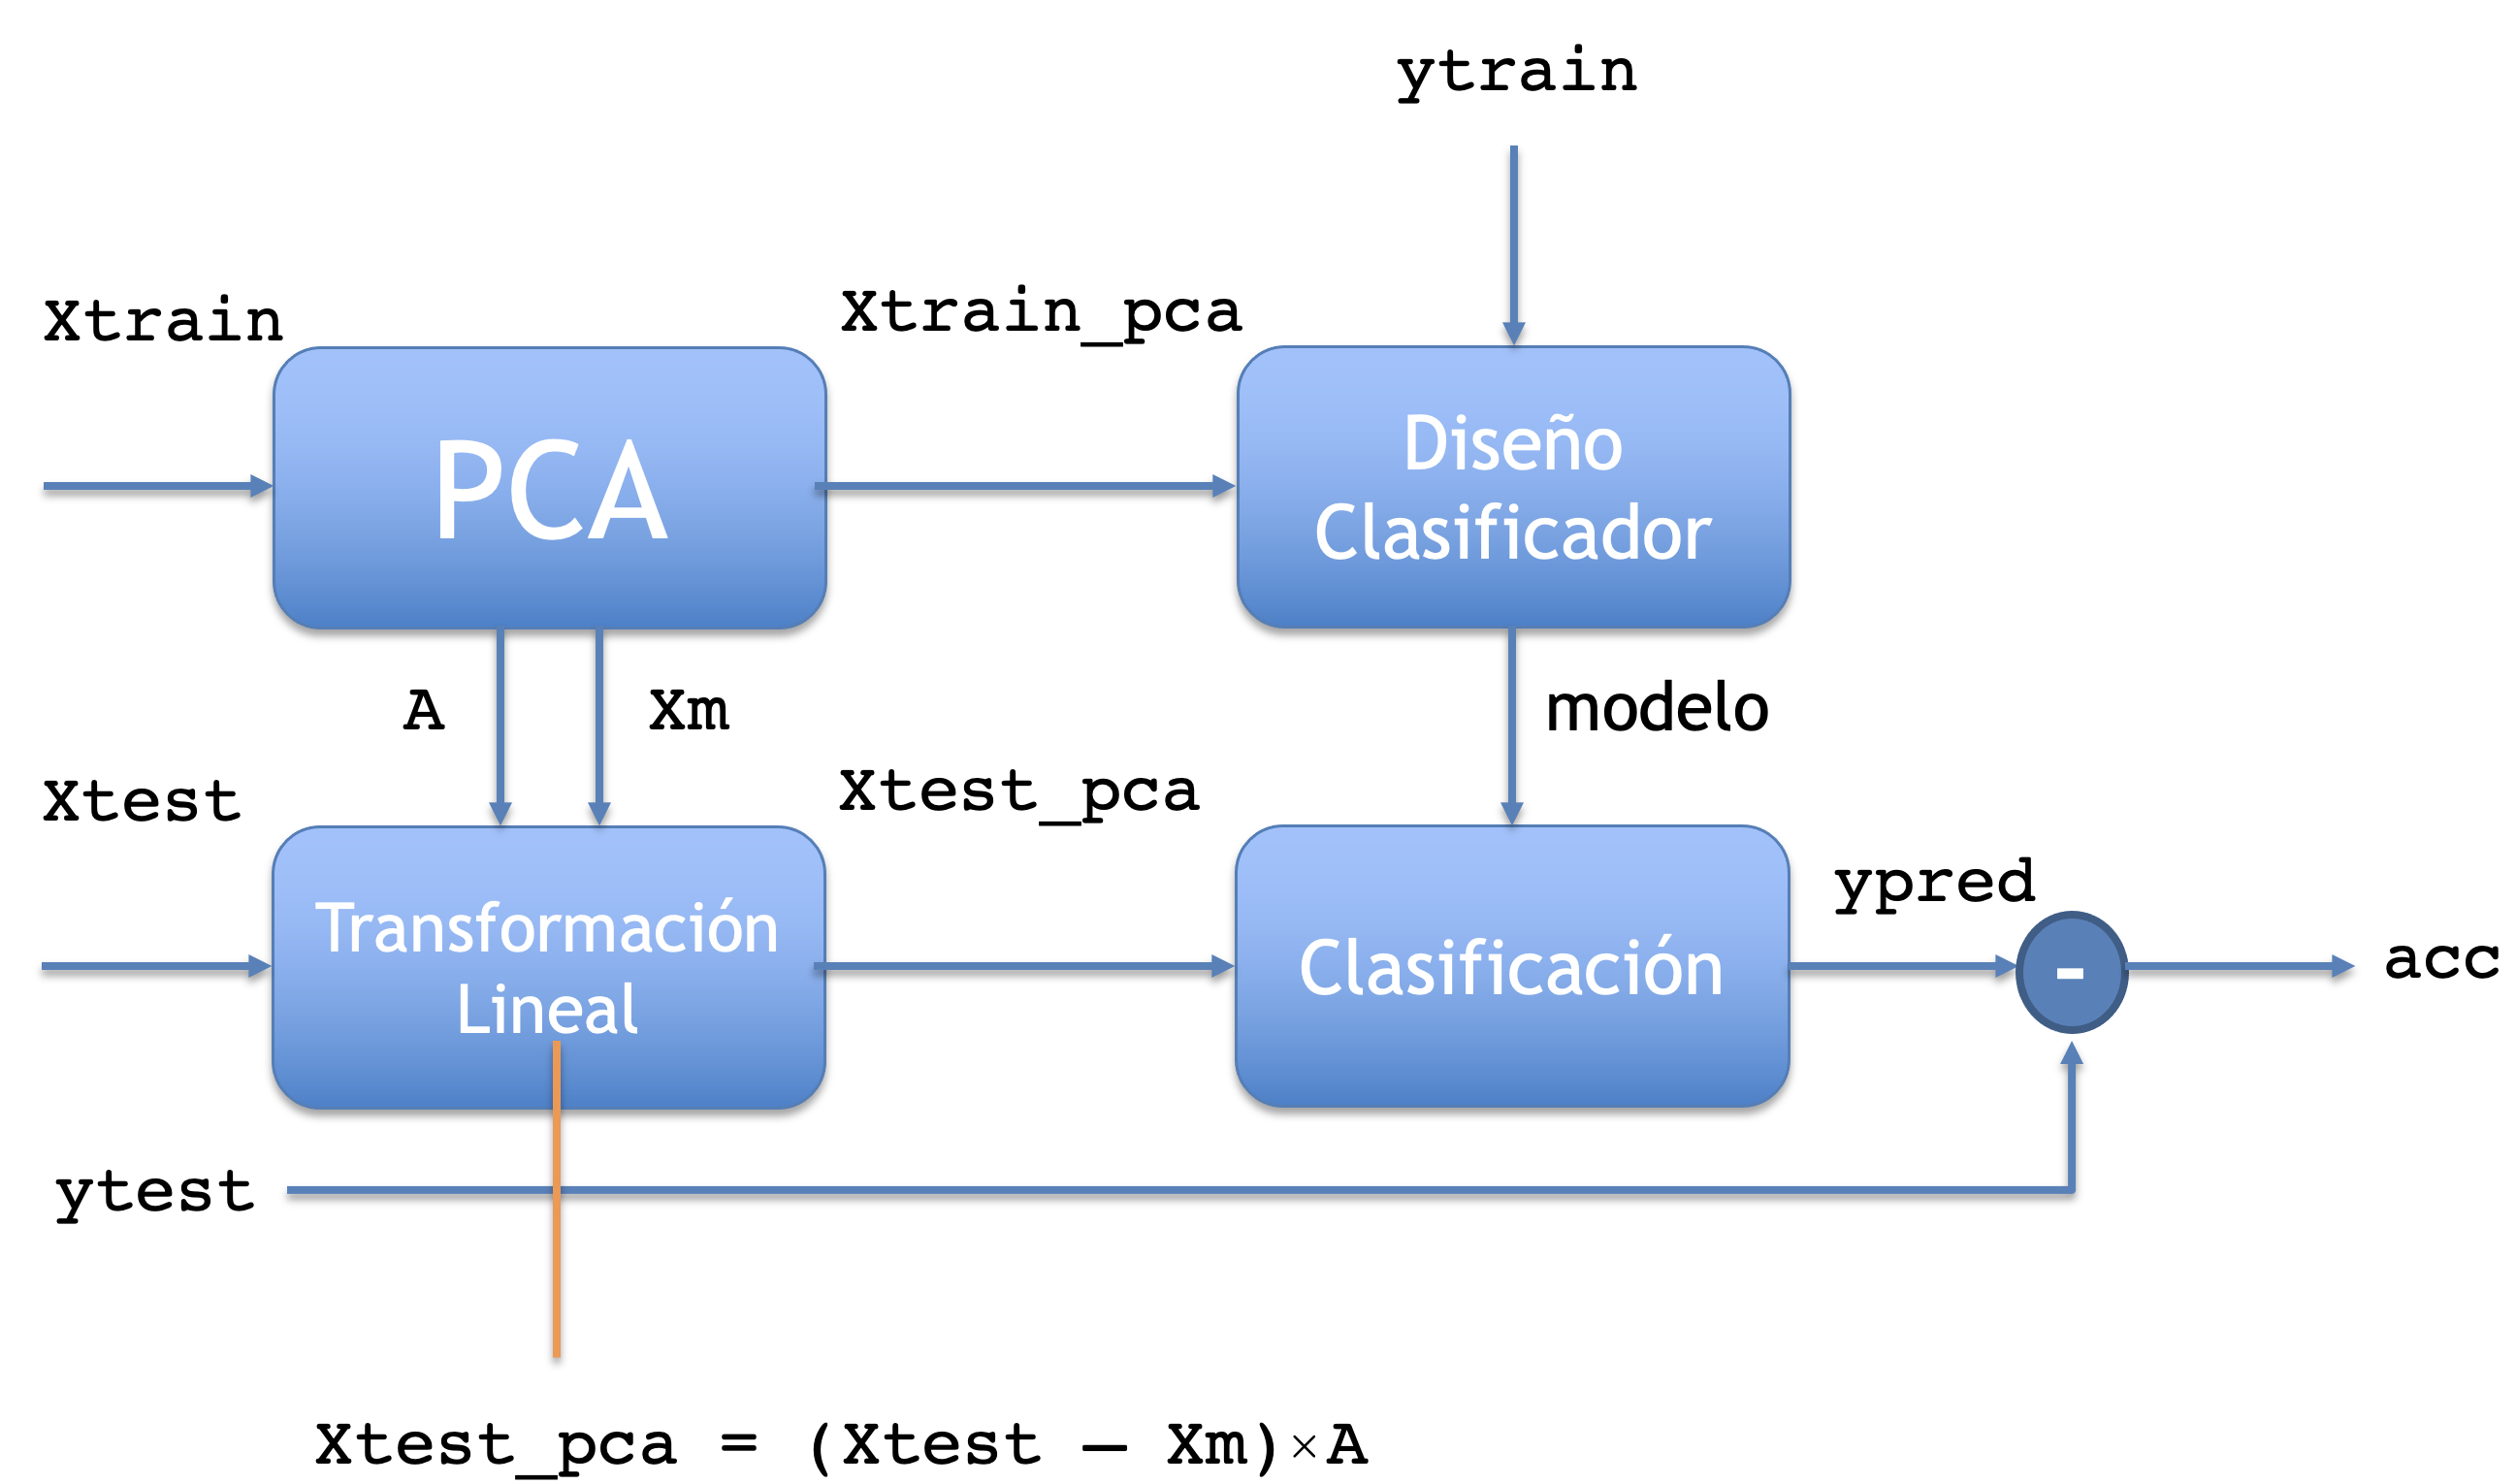

In [15]:
# PCA using normalized data
print()
print('PCA:')
print('====')
q = 24
Xtrain_pca0, _, A, Xm, _ = pca(Xtrain_norm, n_components=q)
Xtest_pca0 = np.matmul(Xtest_norm - Xm, A)

# Normalization
Xtrain_pca0_norm, a, b = minmax(Xtrain_pca0)
Xtest_pca0_norm        = Xtest_pca0 * a + b

# Paso 5: PCA
acc,C = ClassifierKNN(Xtrain_pca0_norm,ytrain,Xtest_pca0_norm,ytest)


PCA:
====
Training with 360 samples. Testing with 40 samples (of 24 features)...
Testing Accuracy = 95.0%
Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


# PCA with SFS

## Estrategy 1: [SFS>PCA]

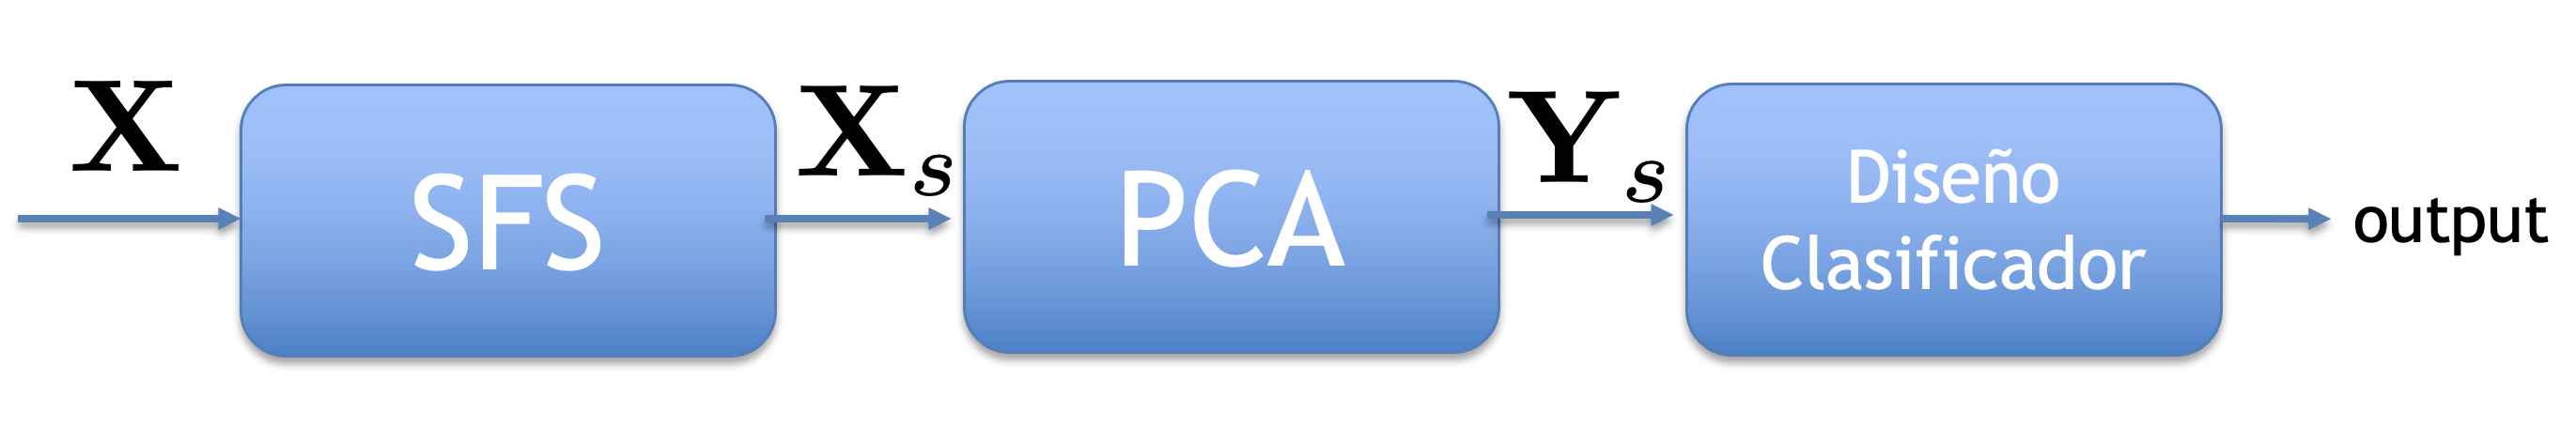

In [16]:
# SFS
p = 50
s1 = sfs(Xtrain_norm,ytrain,p,show=True)
Xtrain_sfs1 = Xtrain_norm[:,s1]
Xtest_sfs1  = Xtest_norm[:,s1]

# PCA
q = 24
Xtrain_pca1, _, A, Xm, _ = pca(Xtrain_sfs1, n_components=q)
Xtest_pca1 = np.matmul(Xtest_sfs1 - Xm, A)

# Normalization
Xtrain_pca1_norm, a, b = minmax(Xtrain_pca1)
Xtest_pca1_norm        = Xtest_pca1 * a + b

# Classification
acc,C = ClassifierKNN(Xtrain_pca1_norm,ytrain,Xtest_pca1_norm,ytest)

AttributeError: type object 'tqdm' has no attribute 'trange'

## Estrategy 2: Combinations: [SFS + PCA]

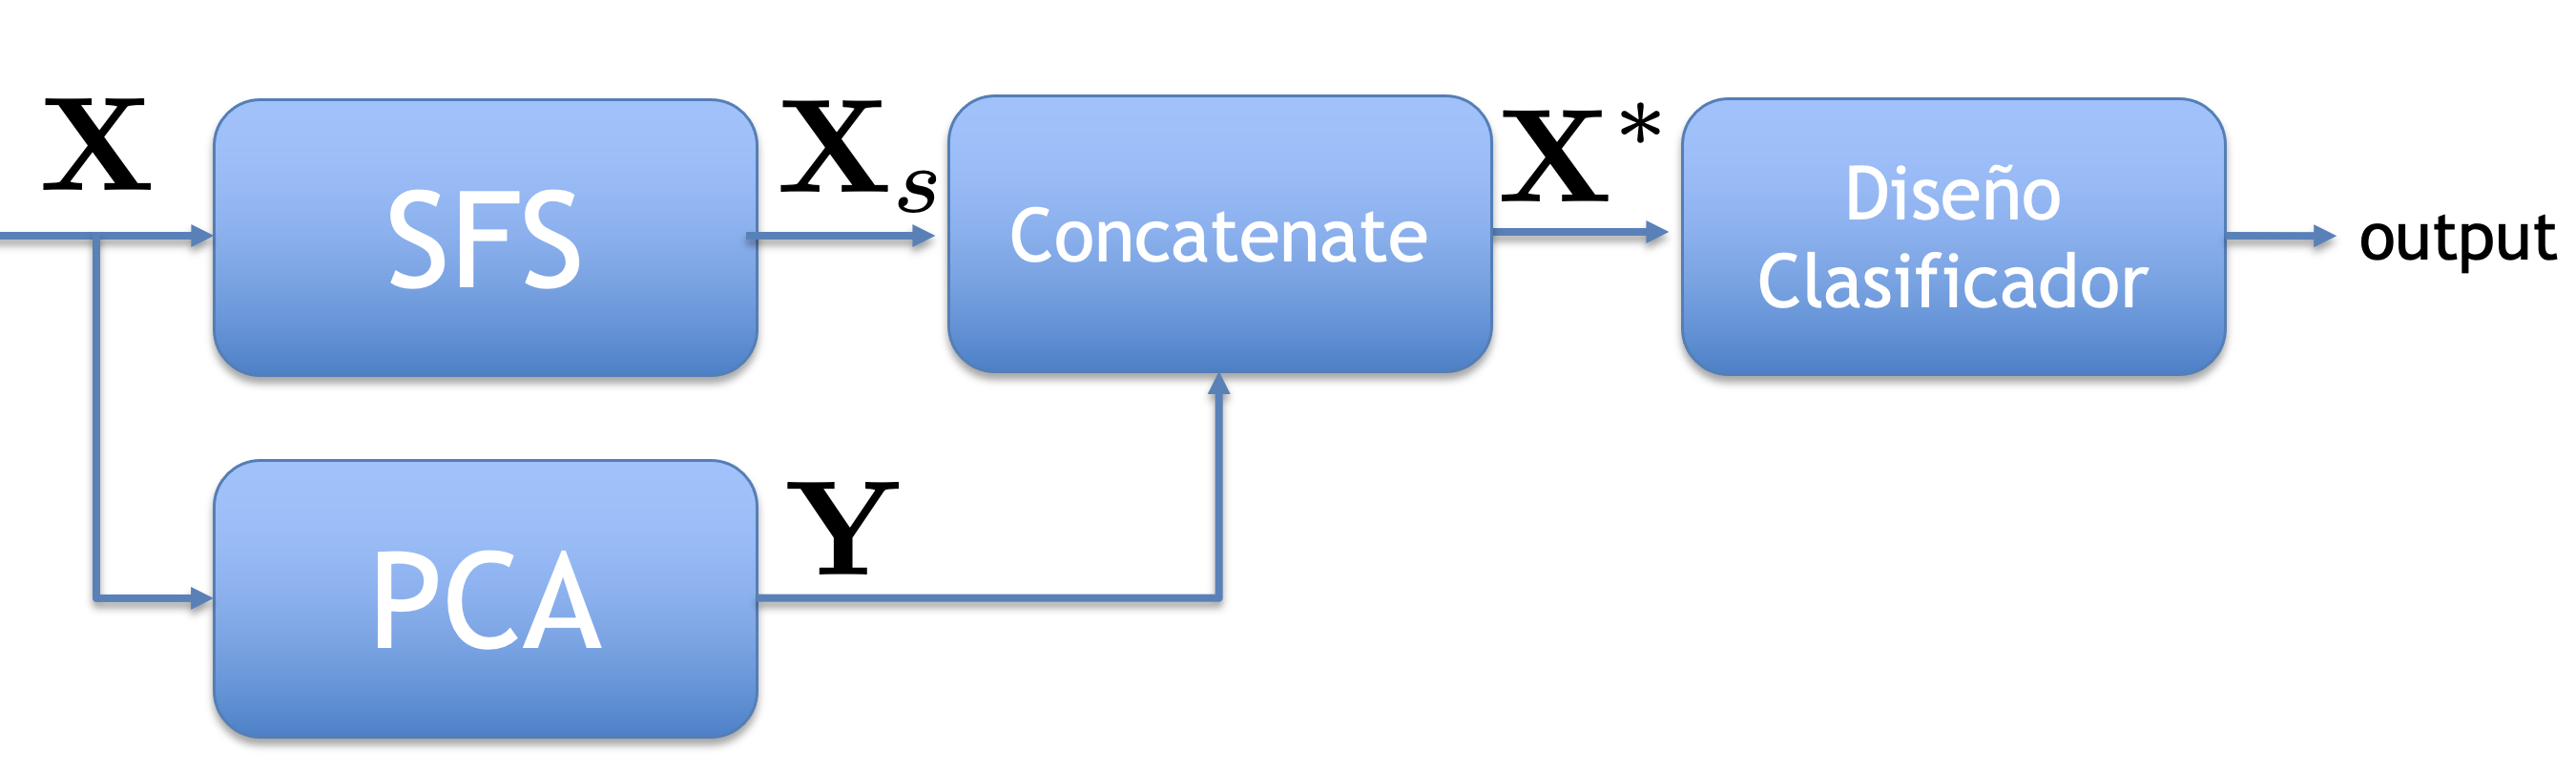

In [104]:
# SFS (from step 1)

# PCA (from step 0)

# Concatenation (p+q features)
Xtrain_new2 = np.concatenate((Xtrain_sfs1,Xtrain_pca0_norm),axis=1)
Xtest_new2 = np.concatenate((Xtest_sfs1,Xtest_pca0_norm),axis=1)

# Classification
acc,C = ClassifierKNN(Xtrain_new2,ytrain,Xtest_new2,ytest)

NameError: name 'Xtrain_sfs1' is not defined

## Estrategy 3: Combinations: [SFS + PCA] > SFS

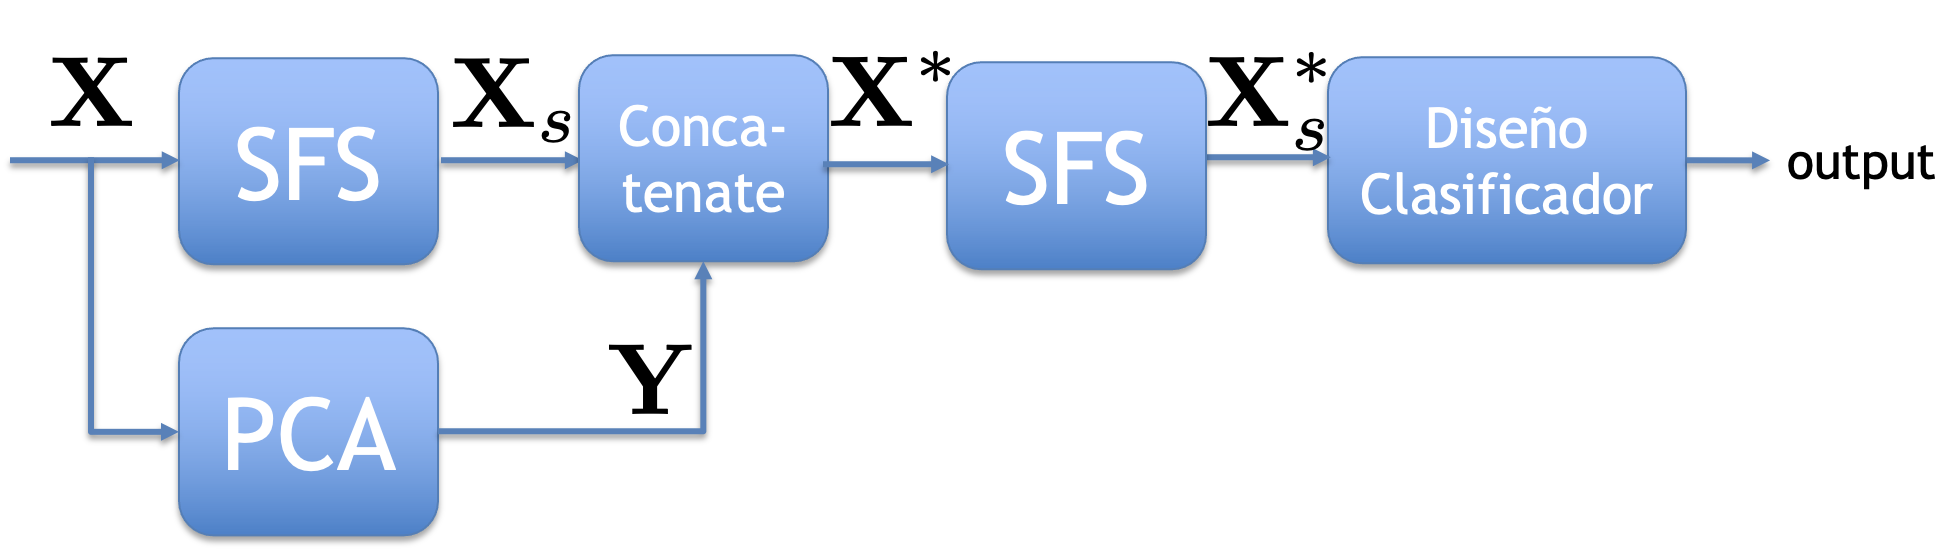

In [105]:
# SFS (from step 1)

# PCA (from step 0)

# Concatenation (p+q features, from previous step)

# SFS (selection of r features from p+q features)
r = 50
s3 = sfs(Xtrain_new2,ytrain,r,show=True)

acc,C = ClassifierKNN(Xtrain_new2[:,s3],ytrain,Xtest_new2[:,s3],ytest)


NameError: name 'Xtrain_new2' is not defined

## Estrategy 4: Combinations: [SFS + [SFS > PCA]] > SFS

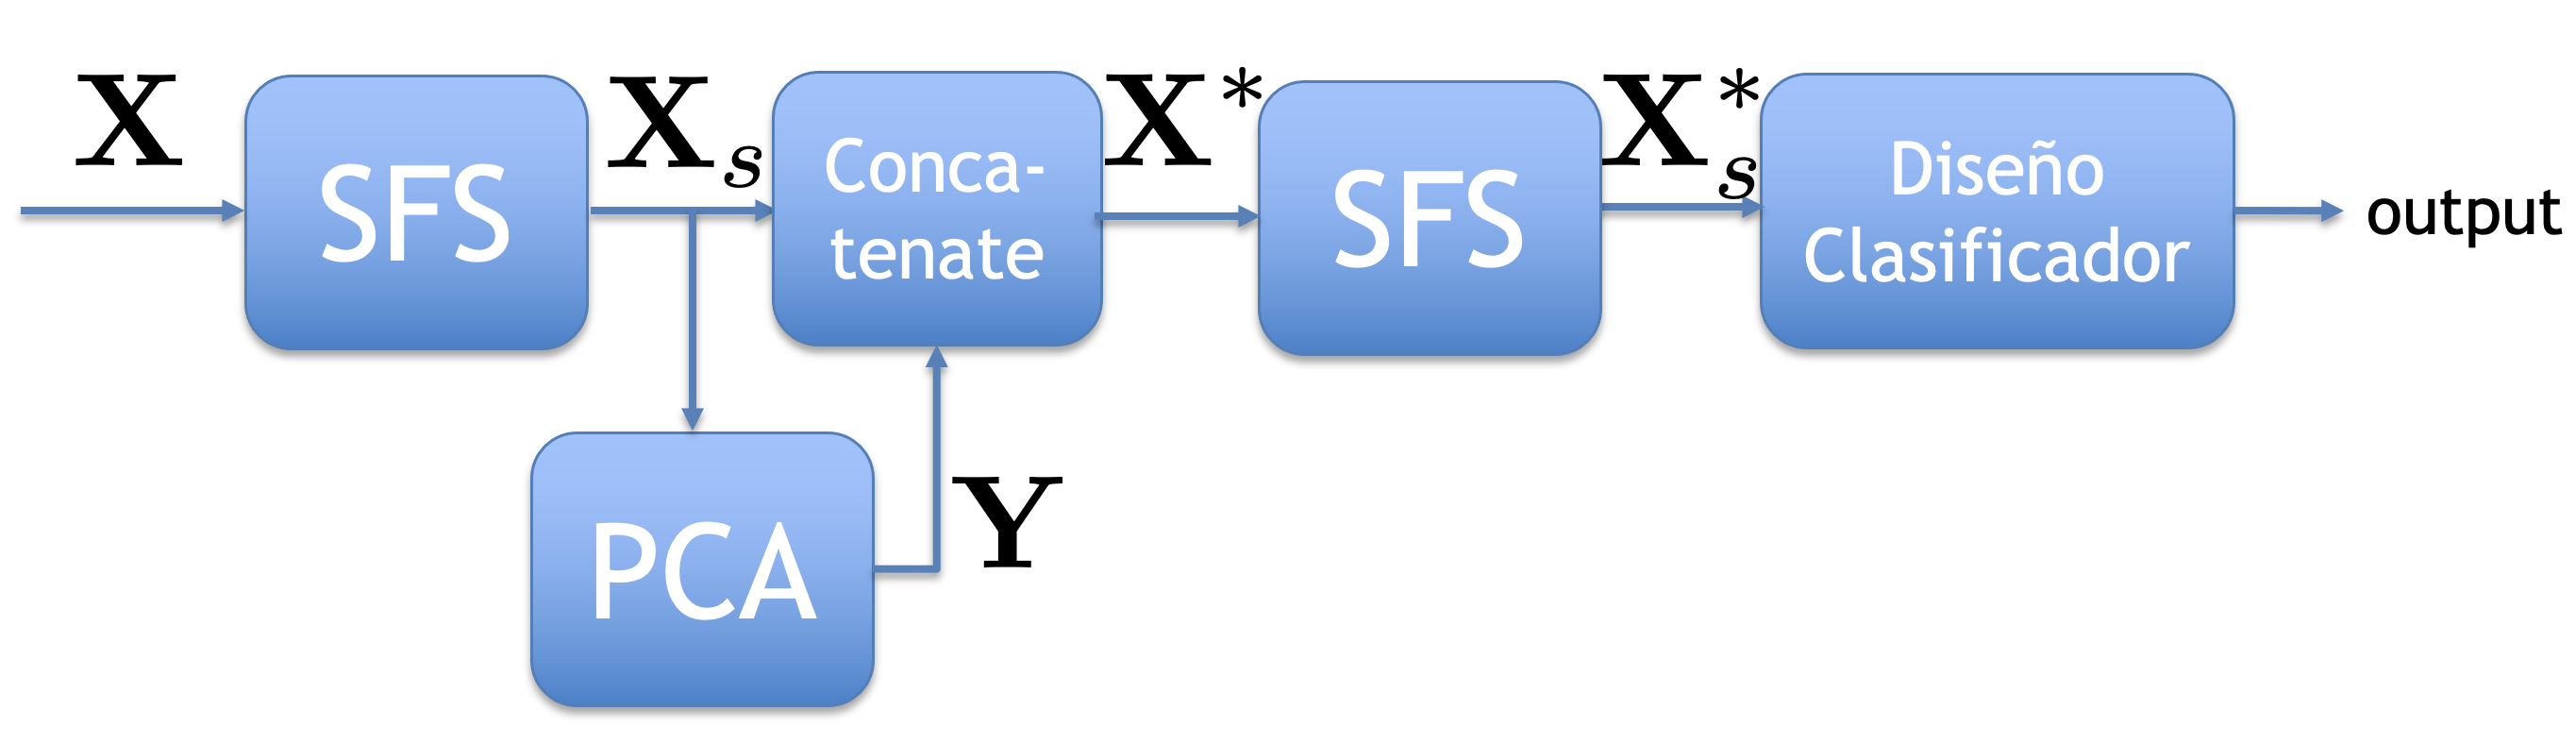

In [106]:
# SFS (from step 1 p features)

# PCA (from step 1 q features)

# Concatenation (p+q features)
Xtrain_new = np.concatenate((Xtrain_sfs1,Xtrain_pca1_norm),axis=1)
Xtest_new = np.concatenate((Xtest_sfs1,Xtest_pca1_norm),axis=1)

# SFS (selection of r features from p+q features)
r = 50
s4 = sfs(Xtrain_new,ytrain,r,show=True)

acc,C = ClassifierKNN(Xtrain_new[:,s4],ytrain,Xtest_new[:,s4],ytest)


NameError: name 'Xtrain_sfs1' is not defined

# Classification with ICA

This example follows the same scheme above but using ICA instead of PCA.

In [107]:
from sklearn.decomposition import FastICA

print()
print('ICA:')
print('====')

ica = FastICA(n_components=20, random_state=0)
ica.fit(Xtrain_norm, ytrain)

Xtrain_ica = ica.transform(Xtrain_norm)
Xtest_ica  = ica.transform(Xtest_norm)

acc,C = ClassifierKNN(Xtrain_ica,ytrain,Xtest_ica,ytest,1)



ICA:
====
Training with 360 samples. Testing with 40 samples (of 20 features)...
Testing Accuracy = 92.5%
Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


# Classification with PLSR
This example follows the same scheme above but using PLSR instead of PCA.

In [108]:
from sklearn.cross_decomposition import PLSRegression


print()
print('PLSR:')
print('=====')


plsr = PLSRegression(n_components=75)

plsr.fit(Xtrain_norm, ytrain)

Xtrain_plsr = plsr.transform(Xtrain_norm)
Xtest_plsr  = plsr.transform(Xtest_norm)

acc,C = ClassifierKNN(Xtrain_plsr,ytrain,Xtest_plsr,ytest,1)





PLSR:
=====
Training with 360 samples. Testing with 40 samples (of 75 features)...
Testing Accuracy = 87.5%
Confusion Matrix:
[[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).